# Bike Sharing

Daily bike rental ridership prediction using an artificial neural network in Keras

This notebook is based on the [first project](https://github.com/udacity/deep-learning/tree/master/first-neural-network) proposed in the [Deep Learning Nanodegree Foundation of Udacity](https://www.udacity.com/course/deep-learning-nanodegree-foundation--nd101Deep). Original solution with Numpy [Here](https://github.com/angelmtenor/deep-learning/blob/master/first-neural-network/dlnd-your-first-neural-network.ipynb)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Load the data

In [2]:
data_path = 'data/Bike-Sharing-Dataset/hour.csv'
df = pd.read_csv(data_path)
df.head()   

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Check out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. We also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. Below is a plot showing the hourly rentals over the first 10 days in the data set. The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week.

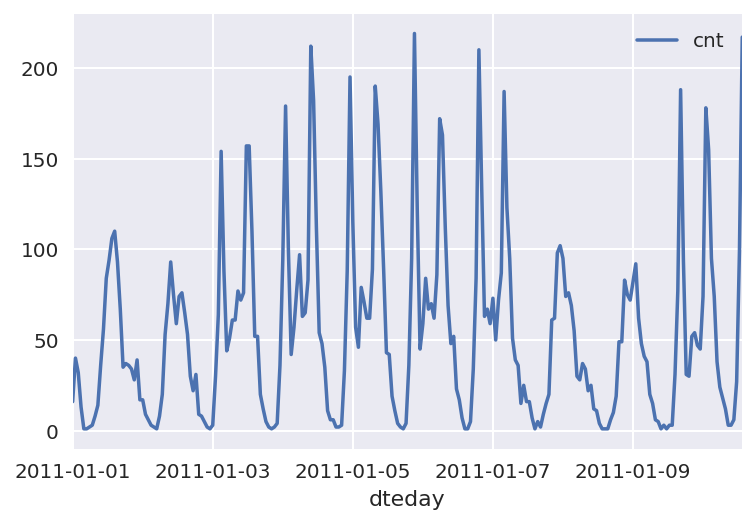

In [3]:
df[:24*10].plot(x='dteday', y='cnt')

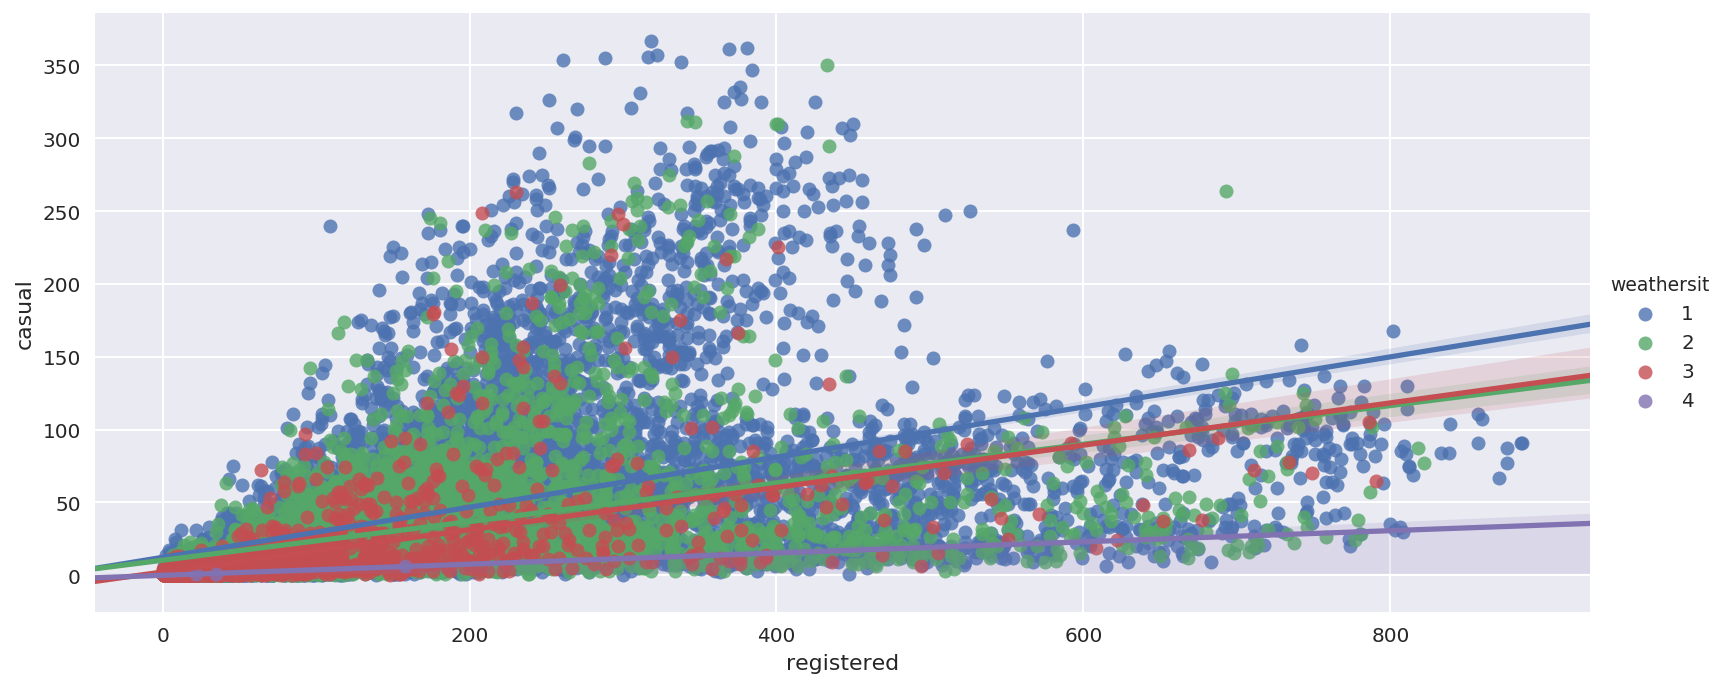

In [4]:
g = sns.PairGrid(df, y_vars='casual', x_vars='registered', size=5, aspect=9/4, hue = 'weathersit')
g.map(sns.regplot).add_legend()

This plot shows the differences between the number of registered and casual riders for the different weather situations. With very bad weather (weathersit=4) most of the riders are registered.

### Select the features

In [5]:
# Remove non-relevant data
fields_to_drop = ['instant', 'dteday', 'atemp', 'workingday']
data = df.drop(fields_to_drop, axis=1)
data.head()  
# once removed, use data instead of df

,season,yr,mnth,hr,holiday,weekday,weathersit,temp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,1,0.24,0.81,0.0,3,13,16
1,1,0,1,1,0,6,1,0.22,0.80,0.0,8,32,40
2,1,0,1,2,0,6,1,0.22,0.80,0.0,5,27,32
3,1,0,1,3,0,6,1,0.24,0.75,0.0,3,10,13
4,1,0,1,4,0,6,1,0.24,0.75,0.0,0,1,1


### Dummy variables

In [6]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(data[each], prefix=each, drop_first=False)
    data = pd.concat([data, dummies], axis=1)
data = data.drop(dummy_fields, axis=1)    

### Scaling target variables
Shift and scale the variables such that they have zero mean and a standard deviation of 1. The scaling factors are saved so we can go backwards when we use the network for predictions.

In [7]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, test, and validation sets

In [8]:
# Save the last 21 days as a test set
test_data = data[-21*24:]
train_data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
train_features, train_targets = train_data.drop(target_fields, axis=1), train_data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [9]:
# Hold out the last 60 days of the remaining data as a validation set
val_features, val_targets = train_features[-60*24:], train_targets[-60*24:]
train_features, train_targets = train_features[:-60*24], train_targets[:-60*24]

## Deep Neural Network
  

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 28)                1596      
_________________________________________________________________
dropout_1 (Dropout)          (None, 28)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 14)                406       
_________________________________________________________________
dropout_2 (Dropout)          (None, 14)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 45        
Total params: 2,047.0
Trainable params: 2,047.0
Non-trainable params: 0.0
_________________________________________________________________
Training ...
Epoch 00152: early stopping
Training loss: 0.101 ... Validation loss: 0.147


(0.042827817488487074, 0.5)

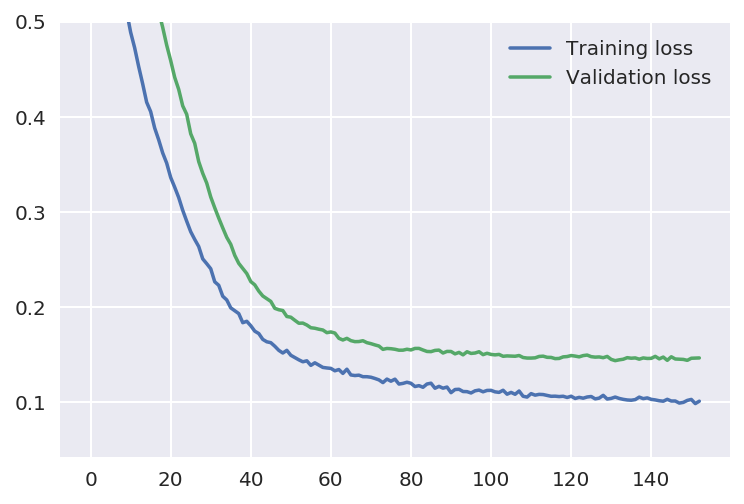

In [10]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU

train_features = np.array(train_features)
train_targets = np.array(train_targets)
val_features = np.array(val_features)
val_targets = np.array(val_targets)
test_features = np.array(test_features)

# Building the model
model = Sequential()
model.add(Dense(28, activation='relu', input_dim = train_features.shape[1]))
model.add(Dropout(.1))
model.add(Dense(14, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(3))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

model.summary()

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)]
print("Training ...")
history = model.fit(train_features, train_targets, epochs=200, batch_size=2048, verbose=0,
         validation_data=(val_features, val_targets), callbacks=callbacks)

print("Training loss: {:.3f} ... Validation loss: {:.3f}".format(history.history['loss'][-1], 
                                                         history.history['val_loss'][-1]))

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.ylim(ymax=0.5)

## Check out the predictions

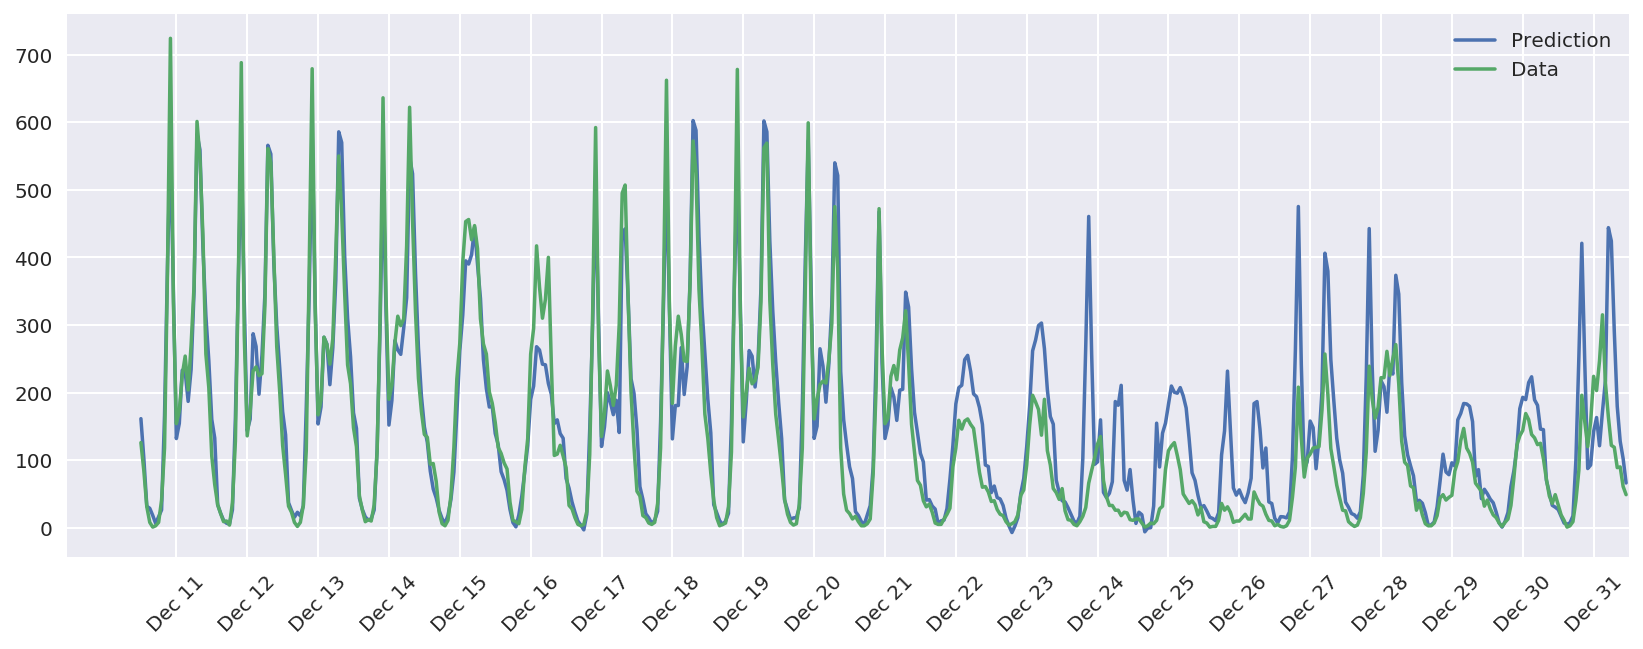

In [11]:
pred = model.predict(test_features)

fig, ax = plt.subplots(figsize=(14,5))

mean, std = scaled_features['cnt']
predictions = pred*std + mean
ax.plot(predictions[:,0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(df.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## Thinking about your results
 
The model seems quite accurate (training loss < 0.10, validation loss < 0.20, from approx 40 epochs) considering that only 2 years of data were available. 

It fails on the last 10 days of December: more bike riders were expected.

The model was not trained to predict this drop: the training set included data from December 22 to December 31 just from one year (2011), which is not enough. A small analysis of the dataset and some tests performed with different models led me to the following results and conclusions:

- Adding more features of the dataset to the model has a negligible impact of the accuracy of the model, just makes the network more complex. Removing or replacing the current features makes the model worse.

    
- The training period Dec 22 - Dec 31 in 2011 had more registered riders (mean = 73.6) than the testing one in 2012 (mean = 58.3). The rest of features, such those related with the weather, were able to predict a little drop (Christmas weather in 2012 was a bit worse than in 2011), but not the decline registered at Christmas 2012. One or more new features could help to predict these anomalies, such as including the number of active registrations, or even a boolean 'Christmas' feature.
    
    

    